In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.concat([pd.read_csv(f'../../../../data/F_feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021, 2022]])
df_test = pd.read_csv('../../../../data/F_feature_selection/feature_selection-2023.csv', sep=';')

In [4]:
df.sort_values(ascending=False, by='speed_limit').head(30)

,location,type_of_collision,latitude,longitude,reserved_lane_present,horizontal_alignment,infrastructure,accident_situation,speed_limit,position,sex,pedestrian_location,pedestrian_action,fixed_obstacle_struck,mobile_obstacle_struck,initial_point_of_impact,main_maneuver_before_accident,motor_type,direction_of_travel_other,fixed_obstacle_struck_other,mobile_obstacle_struck_other,initial_point_of_impact_other,main_maneuver_before_accident_other,motor_type_other,vehicle_category_involved_bicycle,vehicle_category_involved_bus_coach,vehicle_category_involved_hgv_truck,vehicle_category_involved_light_motor_vehicle,vehicle_category_involved_other,vehicle_category_involved_powered_2_3_wheeler,hour_sin,hour_cos,time_of_day,day_of_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,age,age_group,used_belt,used_helmet,used_child_restraint,used_airbag,vehicle_category_simplified,impact_score,vehicle_category_simplified_other,impact_score_other,impact_delta,road_complexity_index,surface_quality_indicator,role,lighting_ordinal,weather_ordinal,injury_target
59992,2,7,43.350250,5.346800,0,3,2,1,901,5,2,-1,-1,4.0,0.0,3.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,1,0,0,1.000000e+00,6.123234e-17,Morning_Rush,6,-0.781831,0.623490,-8.660254e-01,-5.000000e-01,-0.499069,-0.866562,24.0,young_adult,1,0,0,0,light_motor_vehicle,4,NaN,0,4,1.923077,0,passenger,0,0,1.0
59993,2,7,43.350250,5.346800,0,3,2,1,901,4,1,-1,-1,4.0,0.0,3.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,1,0,0,1.000000e+00,6.123234e-17,Morning_Rush,6,-0.781831,0.623490,-8.660254e-01,-5.000000e-01,-0.499069,-0.866562,30.0,adult,1,0,0,0,light_motor_vehicle,4,NaN,0,4,1.923077,0,passenger,0,0,0.0
59994,2,7,43.350250,5.346800,0,3,2,1,901,3,1,-1,-1,4.0,0.0,3.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,1,0,0,1.000000e+00,6.123234e-17,Morning_Rush,6,-0.781831,0.623490,-8.660254e-01,-5.000000e-01,-0.499069,-0.866562,31.0,adult,1,0,0,0,light_motor_vehicle,4,NaN,0,4,1.923077,0,passenger,0,0,0.0
59996,2,7,43.350250,5.346800,0,3,2,1,901,1,-1,-1,-1,4.0,0.0,3.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,1,0,0,1.000000e+00,6.123234e-17,Morning_Rush,6,-0.781831,0.623490,-8.660254e-01,-5.000000e-01,-0.499069,-0.866562,0.0,Unknown,0,0,0,0,light_motor_vehicle,4,NaN,0,4,1.923077,0,driver,0,0,0.0
59995,2,7,43.350250,5.346800,0,3,2,1,901,2,1,-1,-1,4.0,0.0,3.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,1,0,0,1.000000e+00,6.123234e-17,Morning_Rush,6,-0.781831,0.623490,-8.660254e-01,-5.000000e-01,-0.499069,-0.866562,29.0,adult,1,0,0,0,light_motor_vehicle,4,NaN,0,4,1.923077,0,passenger,0,0,0.0
30740,1,5,44.807688,-0.527605,0,1,0,1,900,1,1,-1,-1,0.0,2.0,4.0,2.0,1.0,2.0,0.0,2.0,3.0,1.0,1.0,0,0,0,2,0,1,9.659258e-01,-2.588190e-01,Morning_Rush,3,0.433884,-0.900969,-8.660254e-01,5.000000e-01,-0.974860,0.222820,34.0,adult,1,0,0,0,light_motor_vehicle,4,light_motor_vehicle,4,0,3.461538,1,driver,1,0,0.0
30741,1,5,44.807688,-0.527605,0,1,0,1,900,1,1,-1,-1,0.0,2.0,1.0,2.0,1.0,2.0,0.0,2.0,3.0,1.0,1.0,0,0,0,2,0,1,9.659258e-01,-2.588190e-01,Morning_Rush,3,0.433884,-0.900969,-8.660254e-01,5.000000e-01,-0.974860,0.222820,45.0,middle_aged,0,1,0,0,powered_2_3_wheeler,3,light_motor_vehicle,4,-1,3.461538,1,driver,1,0,1.0
31201,1,3,48.965337,2.474563,0,1,0,1,900,1,1,-1,-1,0.0,2.0,1.0,3.0,1.0,2.0,0.0,2.0,2.0,12.0,0.0,0,0,0,1,0,1,7.071068e-01,-7.071068e-01,Morning_Rush,2,0.974928,-0.222521,-8.660254e-01,5.000000e-01,-0.978548,0.206018,31.0,adult,1,0,0,0,light_motor_vehicle,4,powered_2_3_wheeler,3,1,2.307692,1,driver,0,0,1.0
14774,1,6,48.572613,2.640159,0,1,0,1,900,1,1,-1,-1,0.0,2.0,4.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,0,0,0,3,0,0,-7.071068e-01,-7.071068e-01,Midday,3,0.433884,-0.900969,-5.000000e-01,8.660254e-01,-0.583951,0.811789,47.0,middle_aged,1,0,0,0,light_motor_vehicle,4,light_motor_vehicle,4,0,2.692308,1,driver,0,0,0.0
14775,1,6,48.572613,2.640159,0,1,0,1,900,1,1,-1,-1,0.0,2.0,4.0,2.0,3.0,1.0,0.0,2.0,1.0,2.0,1.0,0,0,0,3,0,0,-7.071068e-01,-7.071068e-01,Midday,3,0.433884,-0.900969,-5.000000e-

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 493368 entries, 0 to 126275
Data columns (total 57 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   location                                       493368 non-null  int64  
 1   type_of_collision                              493368 non-null  int64  
 2   latitude                                       493368 non-null  float64
 3   longitude                                      493368 non-null  float64
 4   reserved_lane_present                          493368 non-null  int64  
 5   horizontal_alignment                           493368 non-null  int64  
 6   infrastructure                                 493368 non-null  int64  
 7   accident_situation                             493368 non-null  int64  
 8   speed_limit                                    493368 non-null  int64  
 9   position                                  

In [5]:
columns_to_drop = [
    'latitude', 'longitude',
    'pedestrian_location', 'pedestrian_action',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'age',
    'direction_of_travel_other'
]

object_type = ['role', 'age_group', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 'time_of_day']

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'sex'
]

columns_to_int32 = [
    'location', 'type_of_collision', 'reserved_lane_present', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position',
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other',
    'motor_type_other','vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck',
    'vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler',
    'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'impact_score', 'impact_score_other', 'impact_delta', 'surface_quality_indicator',
    'lighting_ordinal', 'weather_ordinal', 'injury_target', 'sex', 'day_of_week', 'speed_limit'
]

In [6]:
for x in [df, df_test]:
    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)    
    x.replace(-1, pd.NA, inplace=True)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    x[['vehicle_category_simplified', 'vehicle_category_simplified_other']] = x[['vehicle_category_simplified', 'vehicle_category_simplified_other']].fillna('no vehicle')
    x.dropna(inplace=True)
    x[columns_to_int32] = x[columns_to_int32].astype('int32')
    
    # Drop rows with impossible speed limit
    # France has a maximum speed limit of 130
    x.drop(index=x[x['speed_limit'] > 130].index, inplace=True)
 

/tmp/ipykernel_654/4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)
/tmp/ipykernel_654/4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418804 entries, 0 to 126275
Data columns (total 43 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   location                                       418804 non-null  int32  
 1   type_of_collision                              418804 non-null  int32  
 2   reserved_lane_present                          418804 non-null  int32  
 3   horizontal_alignment                           418804 non-null  int32  
 4   infrastructure                                 418804 non-null  int32  
 5   accident_situation                             418804 non-null  int32  
 6   speed_limit                                    418804 non-null  int32  
 7   position                                       418804 non-null  int32  
 8   sex                                            418804 non-null  int32  
 9   fixed_obstacle_struck                     

In [8]:
num_cols = ['speed_limit', 'day_of_week', 'impact_score', 'impact_score_other', 'impact_delta', 'road_complexity_index', 'surface_quality_indicator', 'lighting_ordinal', 'weather_ordinal']
cat_cols = df.columns.difference(num_cols + ['injury_target'])

In [9]:
X_train = df.drop(columns='injury_target')
y_train = df['injury_target']

X_test = df_test.drop(columns='injury_target')
y_test = df_test['injury_target']

In [10]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LassoCV, RidgeCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, train_test_split

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

#from mord import LogisticIT, LogisticAT

In [11]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy={0:68000, 1:68000, 2:68000})),
    ('classifier', RidgeClassifierCV(alphas=[0.1*x for x in range(1, 101)], scoring='f1_macro'))
])
pipeline.fit(X_train, y_train)

,steps,"[('transform', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

/mnt/c/Users/David/Desktop/PythonKurs/Data_Mining_I/Project/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.72      0.78     51051
           1       0.61      0.54      0.57     39476
           2       0.43      0.74      0.54     17440

    accuracy                           0.66    107967
   macro avg       0.63      0.67      0.63    107967
weighted avg       0.70      0.66      0.67    107967



ImportError: ConfusionMatrixDisplay.plot requires matplotlib. You can install matplotlib with `pip install matplotlib`

Bad pipe message: %s [b' 10.0; Win64; x64; rv:144.0) Gecko/20100101 Firefox/144.0\r\nAccept: text/html,']
Bad pipe message: %s [b'plication/xhtml+xml,application/xml;q=0.9,*/*;q=0.8\r\nAccept-Language: de,en-US;q=0.7,en;q=0.3\r\nA']


In [294]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('classifier', BalancedRandomForestClassifier(n_jobs=14, n_estimators=100, sampling_strategy='not minority', replacement=True, bootstrap=True))
])
pipeline.fit(X_train, y_train)

MemoryError: Unable to allocate 1.56 MiB for an array with shape (204165,) and data type int64

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.86      0.76     51051
           1       0.58      0.22      0.32     39476
           2       0.38      0.63      0.47     17440

    accuracy                           0.59    107967
   macro avg       0.55      0.57      0.52    107967
weighted avg       0.60      0.59      0.55    107967



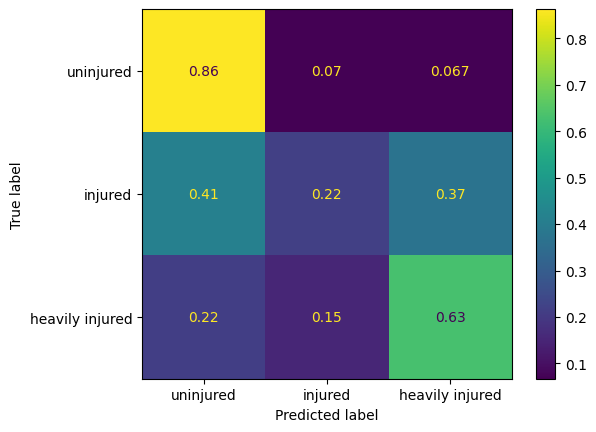

In [293]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', LogisticAT())
])

search_grid = {
    'classifier__alpha': [0.1, 1, 10]
}

randomized_search = RandomizedSearchCV(estimator=pipeline, scoring='f1_macro', n_jobs=3, random_state=42, param_distributions=search_grid)

randomized_search.fit(X_train, y_train)

print(f'Best params: {randomized_search.best_params_}')
print(f'Best score: {randomized_search.best_score_}')

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'classifier__alpha': 1}
Best score: 0.6160105740346877


c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      0.68      0.76     51051
           1       0.53      0.60      0.56     39476
           2       0.45      0.63      0.53     17440

    accuracy                           0.64    107967
   macro avg       0.62      0.63      0.62    107967
weighted avg       0.68      0.64      0.65    107967



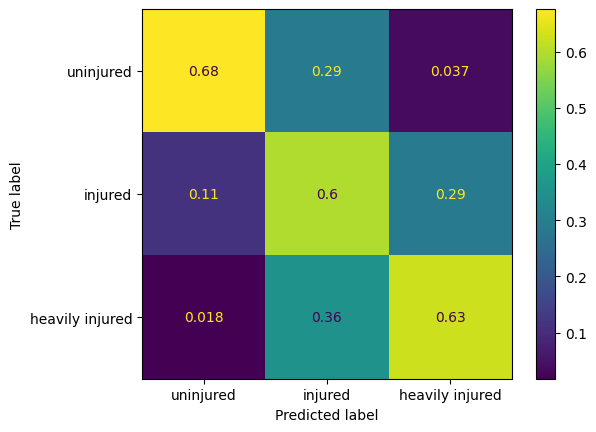

In [255]:
y_pred = randomized_search.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', LassoCV(n_jobs=-1))
])
pipeline.fit(X_train, y_train)

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+01, tolerance: 8.507e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e+01, tolerance: 8.507e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the numb

,steps,"[('transform', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.69      0.77     51051
           1       0.54      0.69      0.60     39476
           2       0.52      0.46      0.49     17440

    accuracy                           0.66    107967
   macro avg       0.64      0.62      0.62    107967
weighted avg       0.68      0.66      0.66    107967



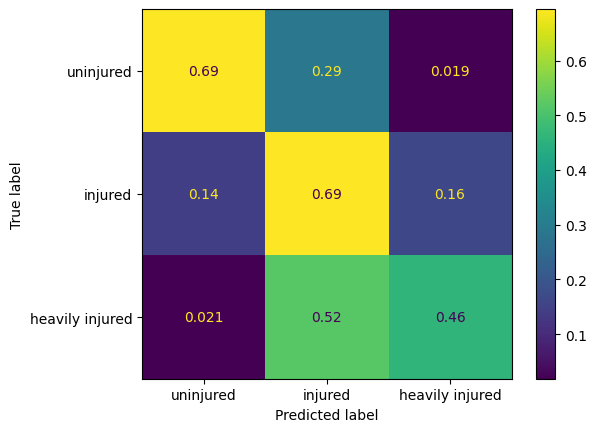

In [271]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True
)

y_cont = pipeline.predict(X_val)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 0, 2).astype(int)

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

# Tune ordinal thresholds on validation
best = (-1, (0.5, 1.5, 2.5))
g1 = np.arange(0.3, 0.8, 0.01)
g2 = np.arange(1.3, 1.8, 0.01)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        yv = apply_thresholds(y_cont, t1, t2)
        score = f1_score(y_val, yv, average='macro')
        if score > best[0]:
            best = (score, (t1, t2))

score, (t1, t2) = best


y_pred_cont = pipeline.predict(X_test)
y_pred = apply_thresholds(y_pred_cont, t1, t2)


print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [275]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', RidgeCV(scoring='neg_root_mean_squared_error'))
])
pipeline.fit(X_train, y_train)

,steps,"[('transform', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.70      0.77     51051
           1       0.54      0.65      0.59     39476
           2       0.50      0.51      0.50     17440

    accuracy                           0.65    107967
   macro avg       0.63      0.62      0.62    107967
weighted avg       0.68      0.65      0.66    107967



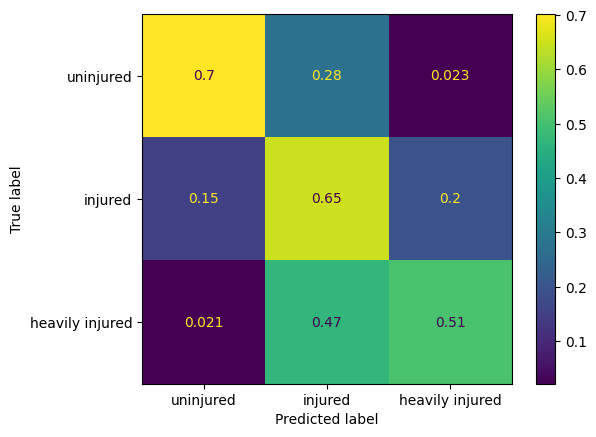

In [279]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True
)

y_cont = pipeline.predict(X_val)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 0, 2).astype(int)

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

# Tune ordinal thresholds on validation
best = (-1, (0.5, 1.5, 2.5))
g1 = np.arange(0.05, 0.95, 0.01)
g2 = np.arange(1.05, 1.95, 0.01)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        yv = apply_thresholds(y_cont, t1, t2)
        score = f1_score(y_val, yv, average='macro')
        if score > best[0]:
            best = (score, (t1, t2))

score, (t1, t2) = best


y_pred_cont = pipeline.predict(X_test)
y_pred = apply_thresholds(y_pred_cont, t1, t2)
#y_pred = round_clip(y_pred_cont)




print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [304]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

transformer = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

X_tr = transformer.fit_transform(X_train)
X_te = transformer.transform(X_test)

# Categorical cols are first block -> indices 0 .. len(cat_cols)-1
cat_idx = list(range(len(cat_cols)))

sw = compute_sample_weight(class_weight='balanced', y=y_train)

gb = HistGradientBoostingClassifier(
    categorical_features=cat_idx,
    learning_rate=0.05,
    max_depth=6,
    max_iter=300,
    min_samples_leaf=50,
    l2_regularization=1.0
)

gb.fit(X_tr, y_train, sample_weight=sw)

,loss,'log_loss'
,learning_rate,0.05
,max_iter,300
,max_leaf_nodes,31
,max_depth,6
,min_samples_leaf,50
,l2_regularization,1.0
,max_features,1.0
,max_bins,255
,categorical_features,"[0, 1, ...]"
,monotonic_cst,None


              precision    recall  f1-score   support

           0       0.87      0.75      0.80     51051
           1       0.64      0.62      0.63     39476
           2       0.48      0.71      0.57     17440

    accuracy                           0.69    107967
   macro avg       0.66      0.69      0.67    107967
weighted avg       0.72      0.69      0.70    107967



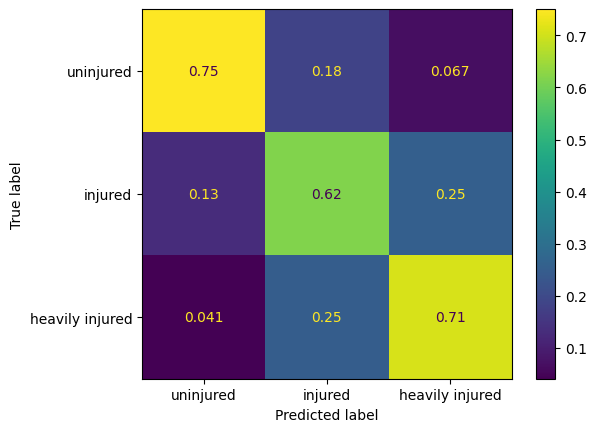

In [305]:
y_pred = gb.predict(X_te)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.svm import LinearSVC


transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=True), cat_cols),
    ('num', StandardScaler(), num_cols),
], remainder='passthrough')

pipeline = ImbPipeline([
    #('sam', RandomUnderSampler(sampling_strategy={1:10000, 2:10000, 3:10000, 4:10000})),
    ('pre', transformer),
    #('en', EasyEnsembleClassifier(estimator=LinearSVC(), sampling_strategy={1:10000, 2:10000, 3:10000}, n_jobs=-1))

    #('en', EasyEnsembleClassifier(estimator=RidgeClassifierCV(class_weight='balanced'), sampling_strategy={1:10000, 2:10000, 3:10000}, n_jobs=-1))
    ('poly', PolynomialFeatures(degree=2)),
    ('en', RidgeClassifier(class_weight='balanced'))
])


pipeline.fit(X_train, y_train)

KeyboardInterrupt: 